In [26]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from torch.utils.data import DataLoader
from generation.data.data_simulation import Nakagami
from generation.data.dataset_pytorch import SignalsDataset
from generation.process.parametrization import GaussianParametrizer
from generation.train.vanila_gan import run_train, generate_new_signal
from scipy import signal
from sklearn.linear_model import Ridge
import tqdm
import pandas as pd

### Data preparation

In [75]:
# Data params
SAMPLE_SIZE = 100
Q_LOWER = 0.001
Q_UPPER = 0.999
NU_MIN = 0.9
NU_MAX = 1.2
NU_STEP = 0.0001

nakagami = Nakagami(SAMPLE_SIZE, Q_LOWER, Q_UPPER)
nu_values = np.arange(NU_MIN, NU_MAX, NU_STEP)
data = nakagami.get_nakagami_data(nu_values)

### Data exploration

In [51]:
import statsmodels.tsa.api as smt
import pandas as pd
import statsmodels.api as sm

In [54]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=len(y)//2, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=len(y)//2, ax=pacf_ax, alpha=0.05)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/datadrive/anaconda3/lib/python3.7/site-package

Критерий Дики-Фуллера: p=0.718109


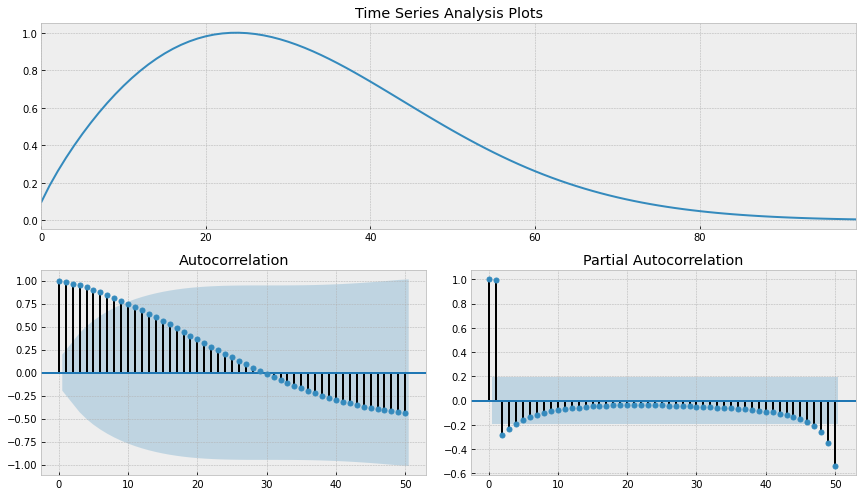

In [55]:
tsplot(data[0])

### Data processing

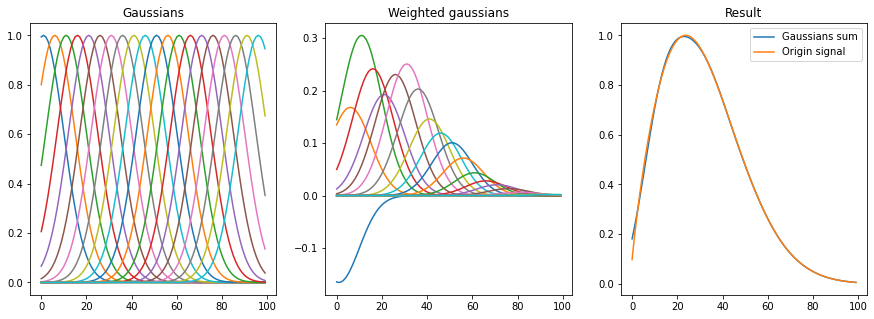

array([-0.16542855,  0.16801291,  0.30515972,  0.24159935,  0.19251718,
        0.23071053,  0.2507914 ,  0.20309874,  0.146028  ,  0.119043  ,
        0.10064587,  0.07160433,  0.04337246,  0.02802135,  0.02058029,
        0.01318894,  0.00624508,  0.00277731,  0.00218918,  0.00207949])

In [60]:
### Parametrization params
GAUSSIAN_STD = 9
COMPRESS_COEF = 5
MODEL = Ridge(alpha=0.1, fit_intercept=False)

gaussian_parametrizer = GaussianParametrizer(COMPRESS_COEF, GAUSSIAN_STD, MODEL)
gaussian_parametrizer.transform_signal(data[0], to_visualize=True)

In [61]:
new_data = gaussian_parametrizer.transform_data(data)

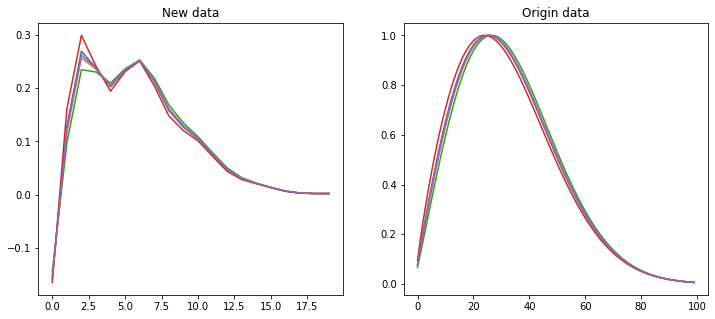

In [62]:
SAMPLES_NUM = 5

f, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title("New data")
ax[1].set_title("Origin data")
for i in range(SAMPLES_NUM):
    idx = np.random.choice(range(len(new_data)))
    ax[0].plot(new_data[idx])
    ax[1].plot(data[idx])
plt.show()

### Training

In [63]:
### Training params
LATENT_DIM = 5
BATCH_SIZE = 128
NUM_EPOCHS = 1000
LEARNING_RATE = 1e-3
PRINT_EACH = 200
VERBOSE = 1
NO_SAVE = True
DEVICE = 'cuda'


dataset = SignalsDataset(new_data)

epoch-0; D_loss: 1.3452482223510742; G_loss: 0.6437812447547913


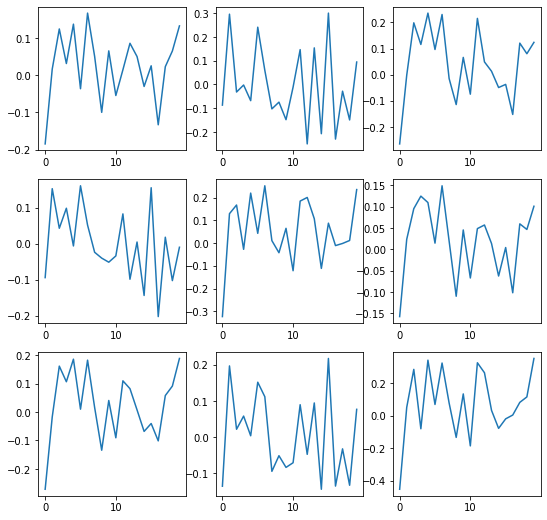

epoch-200; D_loss: 1.3759337663650513; G_loss: 0.6656195521354675


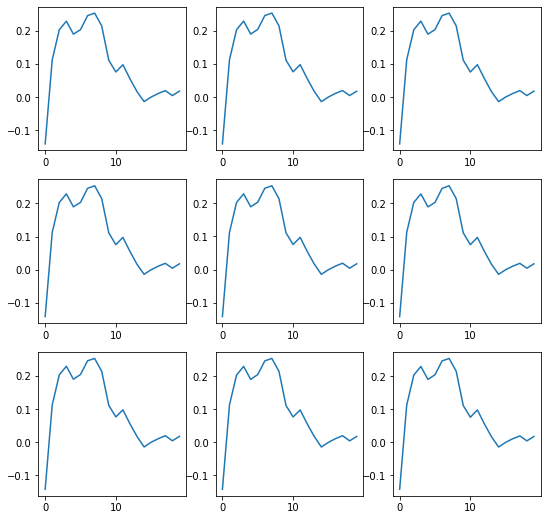

epoch-400; D_loss: 1.7620644569396973; G_loss: 0.5028993487358093


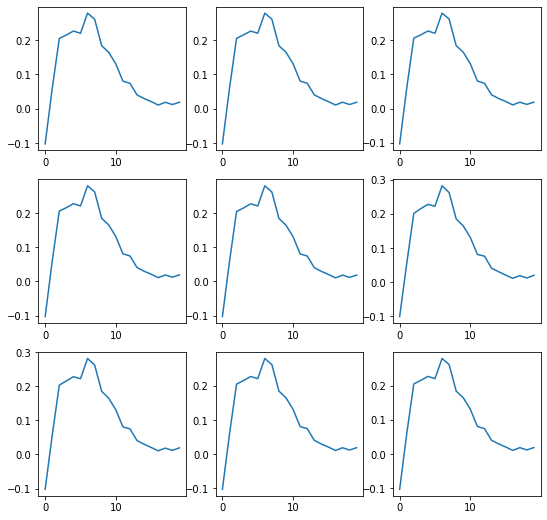

epoch-600; D_loss: 1.4943897724151611; G_loss: 0.7513357400894165


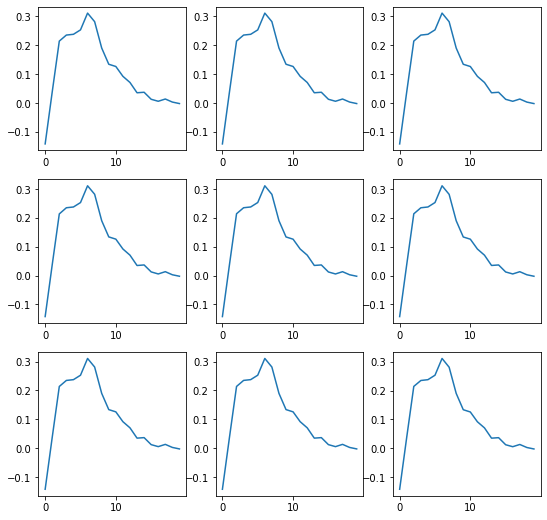

epoch-800; D_loss: 1.335386037826538; G_loss: 0.7192486524581909


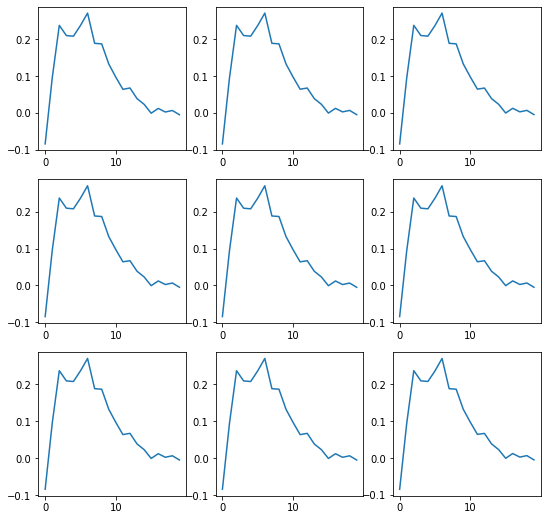

In [64]:
generator = run_train(dataset, \
          latent_dim=LATENT_DIM, \
          sample_size=len(new_data[0]), \
          learning_rate=LEARNING_RATE, \
          num_epochs=NUM_EPOCHS, \
          batch_size=BATCH_SIZE, \
          print_each=PRINT_EACH, \
          verbose=VERBOSE, \
          no_save=NO_SAVE, \
          device=DEVICE)

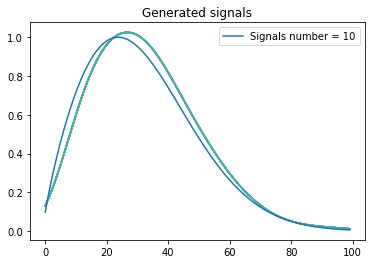

In [73]:
samples = generate_new_signal(generator, device='cuda', signals_num=10)
plt.title("Generated signals")
for sample in samples:
    result = [0] * SAMPLE_SIZE
    gaussians = gaussian_parametrizer.gaussians
    for j in range(len(gaussians)):
        result += sample[j] * gaussians[j]
    plt.plot(result)
plt.legend(["Signals number = {}".format(len(samples))])
plt.plot(data[1])
plt.show()

/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/datadrive/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/datadrive/anaconda3/lib/python3.7/site-package

Критерий Дики-Фуллера: p=0.000273


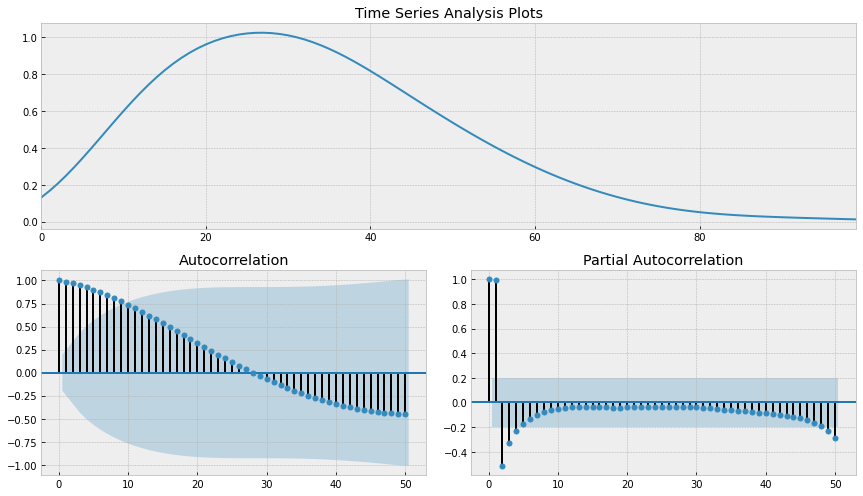

In [74]:
tsplot(result)

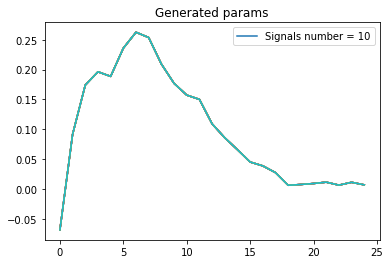

In [22]:
samples = generate_new_signal(generator, device='cuda', signals_num=10)
plt.title("Generated params")
for sample in samples:
    plt.plot(sample)
plt.legend(["Signals number = {}".format(len(samples))])
plt.show()